In [261]:
#Importing all the necessary libraries
import numpy as np 
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [262]:
df=pd.read_csv('Cleaned_Data.csv')
print(df.shape)
df.head()

(11370, 5)


,id,keyword,location,text,target
0,0,ablaze,NaN,communal violence bhainsa telangana stone pelt...,1
1,1,ablaze,NaN,telangana section imposed bhainsa january clas...,1
2,2,ablaze,USA,arsonist set car ablaze dealership,1
3,3,ablaze,"Morgantown, WV",arsonist set car ablaze dealership,1
4,4,ablaze,NaN,lord jesus love brings freedom pardon fill hol...,0


In [263]:
#Checking for Null values
df.isna().sum()

id             0
keyword        0
location    3418
text           3
target         0
dtype: int64

In [264]:
df.dropna(subset = ['text'],inplace=True)

In [265]:
X = df['text']
y = df['target']

### Model

In [266]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=1)
vectorizer=CountVectorizer()
x_train_vectors=vectorizer.fit_transform(X_train)
x_test_vectors=vectorizer.transform(X_test)

In [267]:
X_train.head()

4739     time darkness come ray hope judge kamini lau s...
10684    psychedelic poster ‘ served pulsating visual r...
11089    photographer shooting australia wildfire time ...
6931     texas governor greg abbott r first governor un...
6702     know people bute called brandanes saint brenda...
Name: text, dtype: object

In [268]:
x_train_vectors.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [269]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

In [270]:
train_tfidf

<9093x15230 sparse matrix of type '<class 'numpy.float64'>'
	with 96509 stored elements in Compressed Sparse Row format>

## Logistic Regression - Count Vectorizer

In [271]:
# Fitting Logistic Regression Model on Count Vectorizer using gridsearch_cv
lr = LogisticRegression(random_state=1,class_weight={0:1,1:5},max_iter=10000)
grid_values = {'C': [0.001,0.01,0.1,1,10,100,1000]}
model_lr = GridSearchCV(lr, param_grid=grid_values,cv=4)
model_lr.fit(x_train_vectors,y_train)


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight={0: 1, 1: 5},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [272]:
print(model_lr.best_score_)
print(model_lr.best_estimator_)

0.8736392881754805
LogisticRegression(C=10, class_weight={0: 1, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=1, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


In [273]:
#Getting the best logistic regression model
clf=model_lr.best_estimator_


Accuracy Train:  0.9985703288243704
Accuracy Test:  0.8773087071240105

 Classification Report Train

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7432
           1       0.99      1.00      1.00      1661

    accuracy                           1.00      9093
   macro avg       1.00      1.00      1.00      9093
weighted avg       1.00      1.00      1.00      9093


 Classification Report Test

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1821
           1       0.70      0.68      0.69       453

    accuracy                           0.88      2274
   macro avg       0.81      0.80      0.81      2274
weighted avg       0.88      0.88      0.88      2274


 Confusion Matrix Train



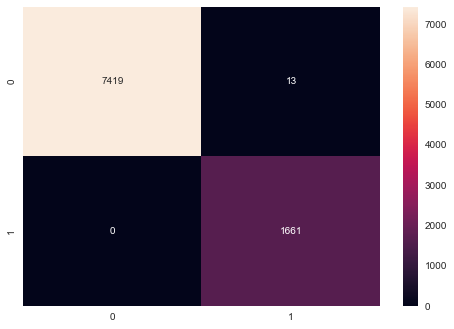


 Confusion Matrix Test



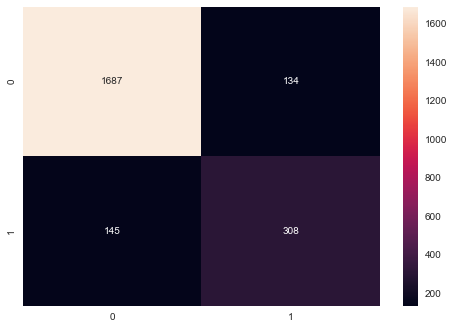

In [274]:
pred=clf.predict(x_test_vectors)
accuracy_score_train=metrics.accuracy_score(y_train,clf.predict(x_train_vectors))
print("Accuracy Train: ",accuracy_score_train)
accuracy_score_test=metrics.accuracy_score(y_test,pred)
print("Accuracy Test: ",accuracy_score_test)
classification_report_train=metrics.classification_report(y_train,clf.predict(x_train_vectors))
print("\n Classification Report Train\n")
print(classification_report_train)
classification_report_test=metrics.classification_report(y_test,pred)
print("\n Classification Report Test\n")
print(classification_report_test)

confusion_matrix_train=metrics.confusion_matrix(y_train,clf.predict(x_train_vectors))
print("\n Confusion Matrix Train\n")
sns.heatmap(confusion_matrix_train,annot=True,fmt="1g")
plt.show()
confusion_matrix_test=metrics.confusion_matrix(y_test,pred)
print("\n Confusion Matrix Test\n")
sns.heatmap(confusion_matrix_test,annot=True,fmt="1g")
plt.show()

## Logistic Regression- Tf-idf vectorizer

In [275]:
# Fitting Logistic Regression Model on Tf-idf vectorizer using gridsearch_cv
lr = LogisticRegression(random_state=1,class_weight={0:1,1:5},max_iter=10000)
grid_values = {'C': [0.001,0.01,0.1,1,10,100,1000]}
model_lr = GridSearchCV(lr, param_grid=grid_values,cv=4)
model_lr.fit(train_tfidf,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight={0: 1, 1: 5},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [276]:
print(model_lr.best_score_)
print(model_lr.best_estimator_)

0.8769384569190307
LogisticRegression(C=10, class_weight={0: 1, 1: 5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=1, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


In [277]:
#Getting the best logistic regression model
clf=model_lr.best_estimator_

Accuracy Train:  0.9888925547124161
Accuracy Test:  0.8777484608619174

 Classification Report Train

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7432
           1       0.94      1.00      0.97      1661

    accuracy                           0.99      9093
   macro avg       0.97      0.99      0.98      9093
weighted avg       0.99      0.99      0.99      9093


 Classification Report Test

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1821
           1       0.68      0.73      0.70       453

    accuracy                           0.88      2274
   macro avg       0.81      0.82      0.81      2274
weighted avg       0.88      0.88      0.88      2274


 Confusion Matrix Train



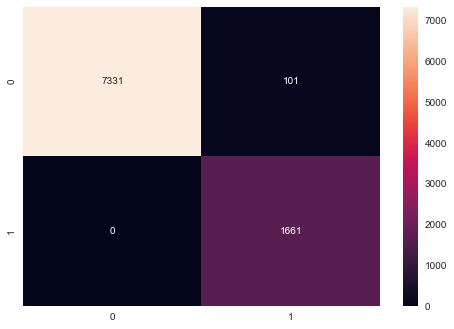


 Confusion Matrix Test



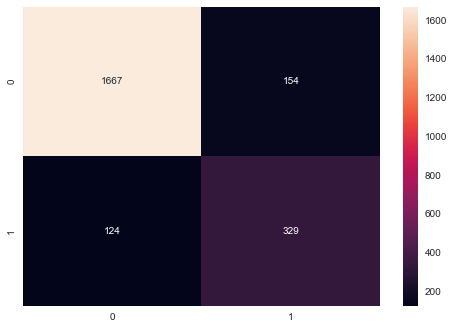

In [278]:
pred=clf.predict(test_tfidf)
accuracy_score_train=metrics.accuracy_score(y_train,clf.predict(train_tfidf))
print("Accuracy Train: ",accuracy_score_train)
accuracy_score_test=metrics.accuracy_score(y_test,pred)
print("Accuracy Test: ",accuracy_score_test)
classification_report_train=metrics.classification_report(y_train,clf.predict(train_tfidf))
print("\n Classification Report Train\n")
print(classification_report_train)
classification_report_test=metrics.classification_report(y_test,pred)
print("\n Classification Report Test\n")
print(classification_report_test)

confusion_matrix_train=metrics.confusion_matrix(y_train,clf.predict(train_tfidf))
print("\n Confusion Matrix Train\n")
sns.heatmap(confusion_matrix_train,annot=True,fmt="1g")
plt.show()
confusion_matrix_test=metrics.confusion_matrix(y_test,pred)
print("\n Confusion Matrix Test\n")
sns.heatmap(confusion_matrix_test,annot=True,fmt="1g")
plt.show()

## Naive Bayes - Count Vectorizer

In [279]:
# Fitting Multinomial Naive Bayes Model on Count vectorizer using gridsearch_cv
nb = MultinomialNB()
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_search= GridSearchCV(nb, parameters)
model_nb = GridSearchCV(lr, param_grid=grid_values,cv=4)
model_nb.fit(x_train_vectors,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight={0: 1, 1: 5},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [280]:
#Getting the best model
clf=model_nb.best_estimator_

Accuracy Train:  0.9985703288243704
Accuracy Test:  0.8773087071240105

 Classification Report Train

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7432
           1       0.99      1.00      1.00      1661

    accuracy                           1.00      9093
   macro avg       1.00      1.00      1.00      9093
weighted avg       1.00      1.00      1.00      9093


 Classification Report Test

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1821
           1       0.70      0.68      0.69       453

    accuracy                           0.88      2274
   macro avg       0.81      0.80      0.81      2274
weighted avg       0.88      0.88      0.88      2274


 Confusion Matrix Train



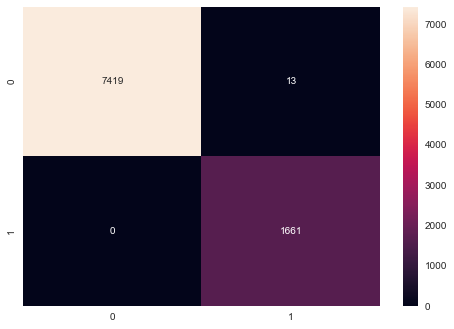


 Confusion Matrix Test



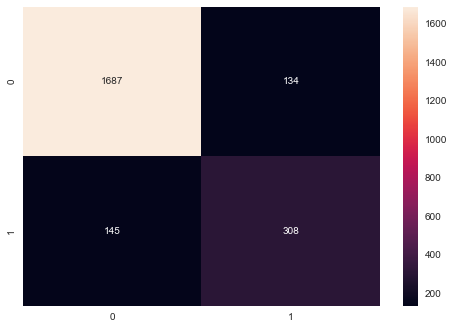

In [281]:
pred=clf.predict(x_test_vectors)
accuracy_score_train=metrics.accuracy_score(y_train,clf.predict(x_train_vectors))
print("Accuracy Train: ",accuracy_score_train)
accuracy_score_test=metrics.accuracy_score(y_test,pred)
print("Accuracy Test: ",accuracy_score_test)
classification_report_train=metrics.classification_report(y_train,clf.predict(x_train_vectors))
print("\n Classification Report Train\n")
print(classification_report_train)
classification_report_test=metrics.classification_report(y_test,pred)
print("\n Classification Report Test\n")
print(classification_report_test)

confusion_matrix_train=metrics.confusion_matrix(y_train,clf.predict(x_train_vectors))
print("\n Confusion Matrix Train\n")
sns.heatmap(confusion_matrix_train,annot=True,fmt="1g")
plt.show()
confusion_matrix_test=metrics.confusion_matrix(y_test,pred)
print("\n Confusion Matrix Test\n")
sns.heatmap(confusion_matrix_test,annot=True,fmt="1g")
plt.show()

## Naive Bayes - TfIdf Vectorizer

In [282]:
# Fitting Multinomial Naive Bayes Model on Tf-idf vectorizer using gridsearch_cv
nb = MultinomialNB()
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
grid_search= GridSearchCV(nb, parameters)
model_nb = GridSearchCV(lr, param_grid=grid_values,cv=4)
model_nb.fit(train_tfidf,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight={0: 1, 1: 5},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [283]:
#Getting the best model
clf=model_nb.best_estimator_

Accuracy Train:  0.9888925547124161
Accuracy Test:  0.8777484608619174

 Classification Report Train

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7432
           1       0.94      1.00      0.97      1661

    accuracy                           0.99      9093
   macro avg       0.97      0.99      0.98      9093
weighted avg       0.99      0.99      0.99      9093


 Classification Report Test

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1821
           1       0.68      0.73      0.70       453

    accuracy                           0.88      2274
   macro avg       0.81      0.82      0.81      2274
weighted avg       0.88      0.88      0.88      2274


 Confusion Matrix Train



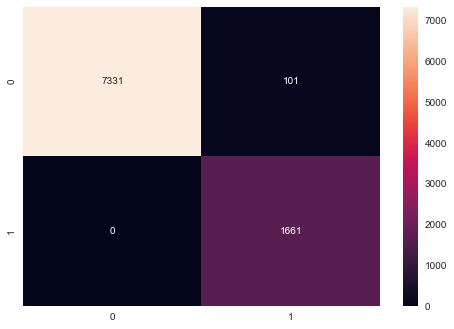


 Confusion Matrix Test



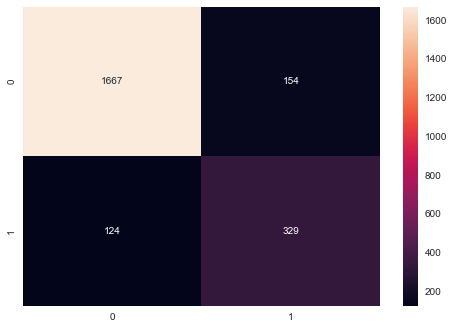

In [284]:
pred=clf.predict(test_tfidf)
accuracy_score_train=metrics.accuracy_score(y_train,clf.predict(train_tfidf))
print("Accuracy Train: ",accuracy_score_train)
accuracy_score_test=metrics.accuracy_score(y_test,pred)
print("Accuracy Test: ",accuracy_score_test)
classification_report_train=metrics.classification_report(y_train,clf.predict(train_tfidf))
print("\n Classification Report Train\n")
print(classification_report_train)
classification_report_test=metrics.classification_report(y_test,pred)
print("\n Classification Report Test\n")
print(classification_report_test)

confusion_matrix_train=metrics.confusion_matrix(y_train,clf.predict(train_tfidf))
print("\n Confusion Matrix Train\n")
sns.heatmap(confusion_matrix_train,annot=True,fmt="1g")
plt.show()
confusion_matrix_test=metrics.confusion_matrix(y_test,pred)
print("\n Confusion Matrix Test\n")
sns.heatmap(confusion_matrix_test,annot=True,fmt="1g")
plt.show()